<a href="https://colab.research.google.com/github/msamunetogetoge/masamune/blob/master/variation_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import poisson
from scipy.special import psi

# ポアソン混合モデル

ポアソン混合モデルを変分推論でフィッティングするクラスを作ります。

In [0]:
class VI():
    def __init__(self,K,x,a,b,alpha):
        self.K =K
        self.x=x
        self.a = a
        self.b =b
        self.alpha =alpha

    def Estep(self):
        self.E_lam = self.a/self.b
        self.E_loglam = psi(self.a) -np.log(self.b)
        self.E_logpi =psi(self.alpha) - psi(np.sum(self.alpha))
        log_eta = np.dot(self.x.reshape(len(self.x), 1), self.E_loglam.reshape(1,self.K)) -self.E_lam + self.E_logpi
        log_eta =log_eta.T-  np.max(log_eta, axis=1)
        self.E_s = (np.exp(log_eta)/np.sum(np.exp(log_eta),axis=0 )).T
        return  self.E_s    

    def Mstep( self):
        self.E_s =self.Estep()
        a_hat =np.dot(self.x, self.E_s ) + self.a
        b_hat = np.sum(self.E_s, axis=0) +self.b
        alpha_hat = np.sum(self.E_s,axis=0)+self.alpha
        return  a_hat , b_hat, alpha_hat

    
    def itr_calc(self,max_itr ):
        A=np.zeros((self.K,max_itr))
        B=np.zeros((self.K,max_itr))
        for i in range(max_itr):
            self.a,self.b,self.alpha = self.Mstep()
            A[:,i]=self.a
            B[:,i]=self.b
        Lam = A/B
        lam = self.a / self.b
        self.E_pi = self.alpha/np.sum

        return lam, Lam 
 

In [0]:
x1 = np.random.poisson(lam=3, size=700)
x2= np.random.poisson(lam=15, size=300)
x=np.append(x1,x2)

In [0]:
K=2
a=np.abs(np.random.randn(K))
b=5*np.abs(np.random.randn(K))
alpha = np.abs(np.random.randn(K))
cal = VI(K=K, x=x, a=a, b=b, alpha=alpha)

In [0]:
lam,Lam, E = cal.itr_calc( max_itr= 1000)

In [179]:
print(lam)
print(cal.E_pi)

[ 2.90780907 14.82726769]
[0.69099361 0.30900639]


良い感じです

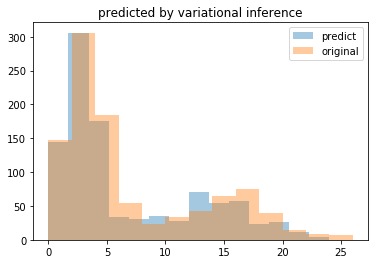

In [52]:
y0= np.random.poisson(lam=lam[0], size=680)
y1= np.random.poisson(lam=lam[1], size=320)
y=np.append(y0,y1)
sns.distplot(y, kde=False, label="predict")
sns.distplot(x, kde=False, label="original")
plt.legend()
plt.title("predicted by variational inference")
plt.savefig("originalvs_predict.png")

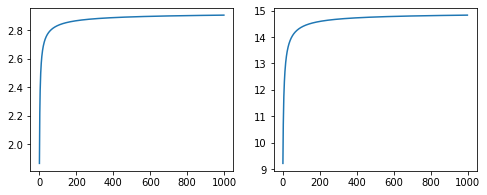

In [180]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(Lam[0])
plt.subplot(1,2,2)
plt.plot(Lam[1])
plt.savefig("conv_lambda.png")

λが収束していることは分かりますが、1000回も計算する必要はなさそうです。elboを監視して、途中で計算を止めるようにします。

In [0]:
class EM_like_VI(VI):
    def Elbo(self):
        a_hat , b_hat, alpha_hat = self.Mstep()
        pi = np.random.dirichlet(self.alpha , size=1)
        self.E_pi = pi/np.sum(pi)
        E_1 = np.dot(self.x.reshape(len(self.x), 1), self.E_loglam.reshape(1,self.K)) -self.E_lam 
        E_1 = np.sum(np.sum(E_1*self.E_s, axis=1))

        E_2 = np.sum(np.dot(self.E_s, self.E_logpi))

        E_3 = np.sum(np.dot(self.E_s, pi.T ))

        E_4 = np.sum((a_hat - self.a)*self.E_loglam - (b_hat - self.b)*self.E_lam )

        E_5 = np.sum( (alpha_hat - self.alpha)*self.E_pi)
        self.elbo = E_1+E_2 -E_3 -E_4 - E_5    
        return self.elbo
    
    def itr_elbo(self,max_itr ):
        E=[]
        A=np.zeros((self.K,max_itr))
        B=np.zeros((self.K,max_itr))
        for i in range(max_itr):
            elbo=self.Elbo()
            self.a,self.b,self.alpha = self.Mstep()
            self.elbo= self.Elbo()
            E=np.append(E,self.elbo) 
            A[:,i]=self.a
            B[:,i]=self.b
            if np.abs(self.elbo - elbo )<0.01 :
                print("Convergence !! n={}".format(i+1))
                break
        Lam = A/B
        lam = self.a / self.b

        return lam, Lam, E
 

In [0]:
K=2
a=np.abs(np.random.randn(K))
b = 10*np.abs(np.random.randn(K))
alpha = np.abs(np.random.randn(K))
cal = EM_like_VI(K=K, x=x, a=a, b=b, alpha=alpha)

In [160]:
lam,Lam, E = cal.itr_elbo( max_itr= 1000)

Convergence !! n=323


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


In [161]:
print(lam)
print(cal.E_pi)

[14.97047597  3.05219385]
[[0.29254975 0.70745025]]


初期値次第では、うまくいかないので、遊んでみると楽しいです。

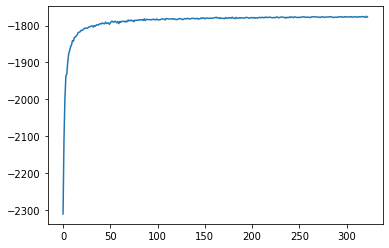

In [163]:
plt.plot(E)

elboが収束しています

# おまけ

交通事故の死亡者をまとめた時系列データをフィッティングしてみます。

In [0]:
X =pd.read_csv("USAccDeaths.csv", index_col=0)
X.head()

,USAccDeaths
1,9007
2,8106
3,8928
4,9137
5,10017


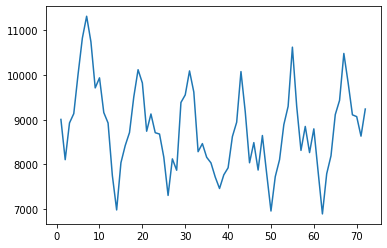

In [0]:
plt.plot(X)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c39c0fd68>]],
      dtype=object)

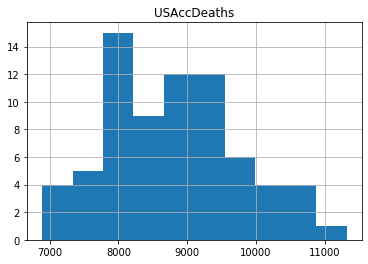

In [0]:
X.hist()

In [0]:
x=np.array(X["USAccDeaths"])

In [0]:
K=2
a=np.abs(np.random.randn(K))
b=10*np.abs(np.random.randn(K))
alpha = np.abs(np.random.randn(K))
cal = EM_like_VI(K=K, x=x, a=a, b=b, alpha=alpha)

In [170]:
lam, Lam, E = cal.itr_elbo(max_itr=1000)
print(lam)
print(cal.E_pi)

Convergence !! n=16
[5.18026932e-02 8.77428522e+03]
[[4.82294338e-05 9.99951771e-01]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


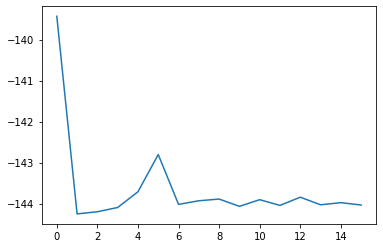

In [173]:
plt.plot(E)

見るからに駄目そうです。

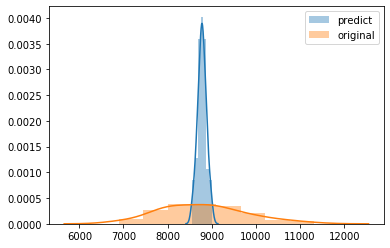

In [175]:
sns.distplot(np.random.poisson(lam=lam[1], size=len(x)), label="predict")　
sns.distplot(x, label="original")
plt.legend()

ポアソン分布は、基本的にとがっているので全然うまくいきません。上手くいかない時も分かって良い感じですね。
正規分布でフィッティングしてみます。

# 正規混合モデル


In [0]:
x=np.array(X["USAccDeaths"]).reshape(-1,1)

In [0]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components =2).fit(x)

In [0]:
gm.weights_

array([0.48020702, 0.51979298])

In [0]:
gm.means_

array([[9436.04569484],
       [8190.83066749]])

In [0]:
labels= gm.predict(X)

In [0]:
colors =["r", "b"]
color=[]
for label in labels:
    color.append(colors[label])
X["color"]=color

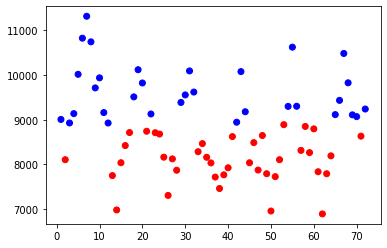

In [0]:
plt.scatter(X.index, X["USAccDeaths"], c=X["color"])

数が増えたときと、減った時で二つに分けれています。

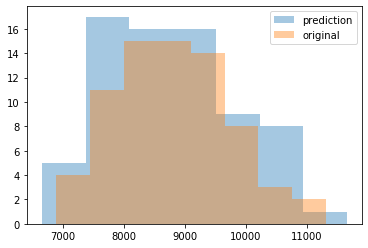

In [0]:
pred = gm.sample(n_samples=len(X))
sns.distplot(pred[0], kde=False , label="prediction")
sns.distplot(X, kde=False, label="original")
plt.legend()

ポアソン混合分布よりはましです。